I start by importing important libraries.

Import Pandas and Numpy for manipulation and handling of data and Seaborn to set a preferred style that will be used for any of our plots to reduce the need for customization.

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")

To start I assign the path and other functions i would wish to the read_csv() function.

I started with the path, then went ahead to read_csv(), upon first inspection I realize that the column index were not formatted properly and that the names had trailing white spaces from either side which would make working with the data frame more difficult, i therefore assigned correct formatted column names to the variable col_names and assigned it to names argument,thereafter i realized that the data set did not start at the expected column headers which was about 4 rows down, i then used header argument to set where the data should start from.

Upon Further inspection the first eleven rows were irregular, i used the Skiprows argument to remove the irregular rows so as not to skew the findings upon subsequent computation.

Finally i realized the data was entered with commas resulting in the data being read as strings instead of numbers, i could have used a for loop to clean it but i opted to use a function instead, i used a lambda function to replace the commas and used the converters argument to apply it to the affected columns.

In [19]:
debt_path = "./Public Debt.csv"
col_names = ['Year', 'Month', 'Domestic_Debt', 'External_Debt', 'Total']
int_func = lambda x: x.replace(",", "")
df = pd.read_csv(debt_path,
                 header=3,
                 names=col_names,
                 skiprows=10,
                 converters={"Domestic_Debt": int_func,"External_Debt": int_func, "Total": int_func}
                 )
df

,Year,Month,Domestic_Debt,External_Debt,Total
0,2001,1,193332.95,403645.68,596978.63
1,2001,2,199537.27,402555.40,602092.67
2,2001,3,200622.58,403373.54,603996.12
3,2001,4,210581.44,402308.31,612889.75
4,2001,5,202880.88,408100.64,610981.52
...,...,...,...,...,...
280,2024,5,5319887.458,5118306.595,10438194.05
281,2024,6,5410300,5150839.749,10561139.75
282,2024,7,5452995.533,5162853.57,10615849.1
283,2024,8,5558345.45,5176101.992,10734447.44


We are also going to use another data frame with some gdp data for further analysis further ahead.We read the data frame and do some cleaning, this is due to the fact that some headers contain trailing white spaces which will be a problem if we let them remain.We also drop Month since It has no value. and since we will be performing timeseries analysis we turn the year porton to a date-time and set it as the Index.

In [20]:
gdp_path = "./Annual GDP.csv"
col_names = ["Year", "Month", "Nominal_Gdp", "Real_Gdp_Growth", "Real_Gdp"]
gdp_df = pd.read_csv(gdp_path, names=col_names, header=1)
gdp_df.drop("Month", axis=1, inplace=True)
gdp_df["Year"] = pd.to_datetime(gdp_df["Year"], format='%Y')
gdp_df.set_index("Year", inplace=True)

The debt data frame had no date time and only provided the month and year, for better handling of the data i decided it was best to work with a date time when working with the time series. I first joined each month and their respective year together and turned the string date to a date time format, this then cpmpleted the format by assigning the day portion as the first day of each month and set the now complete date as the index.

The values in the data frame still read as an object thefore for computational purposes i converted them to float64.

Now that we had a complete Date column, there was no need to keep the "year" and "month" columns i therefore decided to drop them, for their respective use i would use the datetime.

In [21]:
string_date = df['Year'].astype(str)+"-"+df['Month'].astype(str)
df["Date"] = pd.to_datetime(string_date, format="%Y-%m")
df.set_index("Date", inplace=True)
df = df.astype({"Domestic_Debt": "float64", "External_Debt": "float64", "Total": "float64"})
df.drop(columns=["Year", "Month"], inplace=True)
df

,Domestic_Debt,External_Debt,Total
Date,,,
2001-01-01,193332.950,403645.680,596978.63
2001-02-01,199537.270,402555.400,602092.67
2001-03-01,200622.580,403373.540,603996.12
2001-04-01,210581.440,402308.310,612889.75
2001-05-01,202880.880,408100.640,610981.52
...,...,...,...
2024-05-01,5319887.458,5118306.595,10438194.05
2024-06-01,5410300.000,5150839.749,10561139.75
2024-07-01,5452995.533,5162853.570,10615849.10


Inspection of the tail of the data frame revealed that the end was also incomplete and would therefore affect the result of subsequent calculations. I therefore decided to use only the part of the data frame with complete data.

We still have over two decades worth of data and therefore we will still retain valuable information without having to affect the quality of the analysis.

In [22]:
df.tail()
df = df.iloc[:-9, :]

To check if the was any null value i used the info() method on the data frame.There were no missing values and i also confirmed that the data types were correct.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 276 entries, 2001-01-01 to 2023-12-01
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Domestic_Debt  276 non-null    float64
 1   External_Debt  276 non-null    float64
 2   Total          276 non-null    float64
dtypes: float64(3)
memory usage: 8.6 KB


I used describe to check the overall Statistics of the data.

In [24]:
df.describe()

,Domestic_Debt,External_Debt,Total
count,2.760000e+02,2.760000e+02,2.760000e+02
mean,1.494637e+06,1.559089e+06,3.053726e+06
std,1.384210e+06,1.482541e+06,2.862412e+06
min,1.933330e+05,3.617312e+05,5.969786e+05
25%,3.745409e+05,4.249141e+05,7.954635e+05
50%,8.925468e+05,7.857970e+05,1.631176e+06
75%,2.382547e+06,2.562402e+06,4.920319e+06
max,5.050109e+06,6.089585e+06,1.113969e+07


I first used plot to draw a lineplot of the dataframe and get a sense of the overal trend of the data.

It seemed that there was generally an upward trend of the amount of debt both domestic and external debt

<Axes: title={'center': 'Domestic & External Debt'}, xlabel='Date', ylabel='Amount in Millions'>

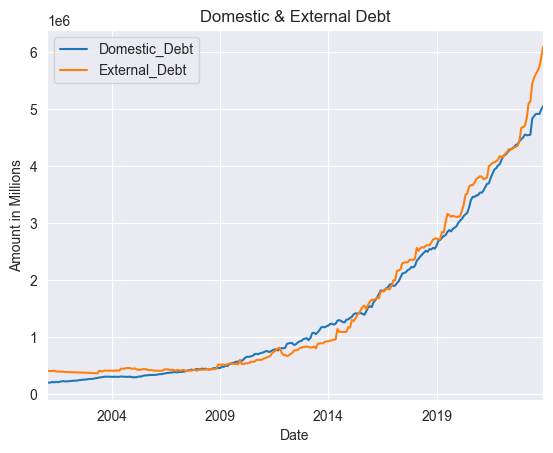

In [25]:
df.plot(title="Domestic & External Debt",
        ylabel="Amount in Millions",
        y=["Domestic_Debt", "External_Debt"])

The plot shows a rising trend in both domestic and external debt...it seems to be climbing faster arround 2008 onwards. What comes to mind wasthe world financial crisis of 2008.It can also be noted that around this period kenya had post election violence which on the after math may have necessitated more borrowing.

C:\Users\daniel\AppData\Local\Temp\ipykernel_9108\1630519332.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  changes_per_year = df.resample("Y").mean().pct_change()*100


,Domestic_Debt,External_Debt,Total,High_ext__debt
Date,,,,
2001-12-31,NaN,NaN,NaN,False
2002-12-31,14.406371,-4.856167,1.824098,False
2003-12-31,19.271276,3.226698,9.478542,False
2004-12-31,4.959983,11.043759,8.461143,True
2005-12-31,4.792494,-0.974749,1.394466,False
2006-12-31,14.083244,-2.435670,4.577811,False
2007-12-31,12.766514,-0.972011,5.391174,False
2008-12-31,8.707131,6.310883,7.498406,False
2009-12-31,18.205794,20.019673,19.110650,True


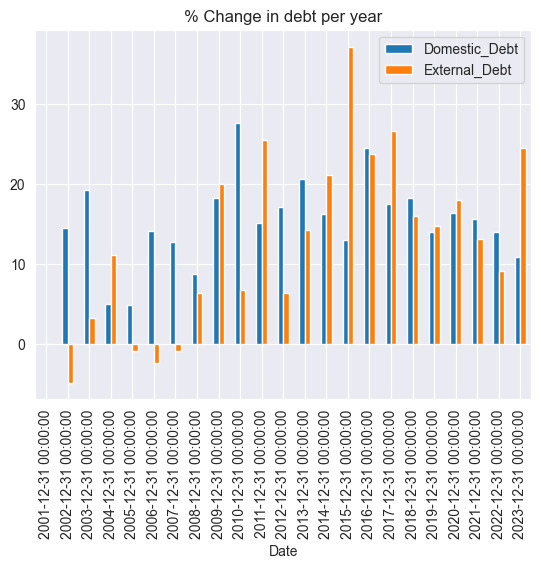

In [26]:
changes_per_year = df.resample("Y").mean().pct_change()*100
changes_per_year.plot.bar(title="% Change in debt per year",
                          y=["Domestic_Debt", "External_Debt"])

changes_per_year.assign(High_ext__debt = changes_per_year["Domestic_Debt"]<=changes_per_year["External_Debt"])

It can be seen with this code that after 2009 we started seeing biger spikes in changes of the average debt per year. This can be seen clearly for the two years, that is 2009 and 2010, that domestic and external debt had a surge in positive change.

It can also be seen that in 2015 there was a big change in external debt.

Further analysis shows that External debt usually had more positive/upward changes as compared to domestic debt, in the twenty three years worth of data only nine years had domestic debt have more change than external debt this being only 39% of the time

The following code was used to check the difference in the changes of debt, that is to check how the did compared to one another

,Domestic_Debt,External_Debt,Total,change_diff
Date,,,,
2001-12-31,NaN,NaN,NaN,NaN
2002-12-31,14.406371,-4.856167,1.824098,19.262538
2003-12-31,19.271276,3.226698,9.478542,16.044578
2004-12-31,4.959983,11.043759,8.461143,-6.083776
2005-12-31,4.792494,-0.974749,1.394466,5.767243
2006-12-31,14.083244,-2.435670,4.577811,16.518913
2007-12-31,12.766514,-0.972011,5.391174,13.738525
2008-12-31,8.707131,6.310883,7.498406,2.396249
2009-12-31,18.205794,20.019673,19.110650,-1.813880


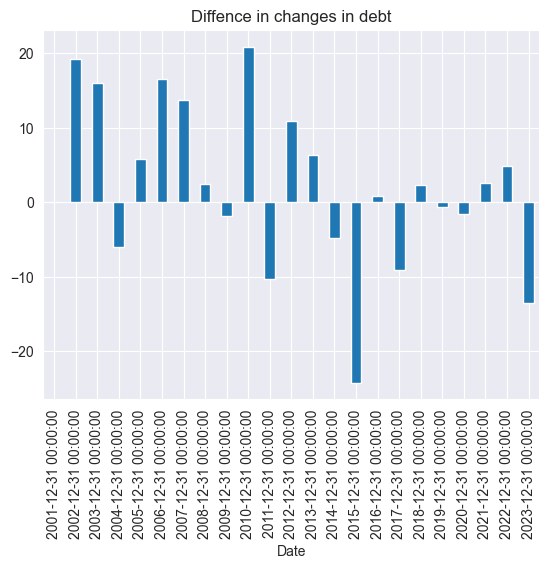

In [27]:
changes_per_year["change_diff"] = changes_per_year["Domestic_Debt"] - changes_per_year["External_Debt"]
changes_per_year['change_diff'].plot.bar(title="Diffence in changes in debt")
changes_per_year

The above figure shows in each year how much the changes were. The positive values represents when the change in domestic debt was higher than that of external debt of the same year, while the negative values show when the change in external debt was higher.

It can be derived that Domestic debt has been on the rise over the years with the country seemingly increasing domestic borrowing. From the plot, one patricular year stands out and that is 2015 where the seemed to be a big change in external debt, this can be attributed to large infrastructure development projects specificaly the Standard Guage Railway(SGR) which was financed heavily by loans from china. For Domestic debt it can be seen that it had big surges in 2002 and 2010, these can be attributed to several factors. in 2002 Kenya it was election period and the government is said to have undertaken a bulk of infrastructure projects at this time. in 2010 the rise in domestic debt can be attributed to the global financial crisis and post election violence, it can also be noted that this was the period kenya was implimenting its new constitution.

In the following code, i want to do an analysis gdp and The total debt. I will only need the total, which i resample by mean to get yearly averages.
To do analysis with the gdp_df i had to change its index so that it could match from the default df.I made a copy of the gdp_df and decided to reset all the indexes to only show the year. i Joined the nomonal_gdp to our default df and performed the necessary calculation foe debt to gdp ratio.


C:\Users\daniel\AppData\Local\Temp\ipykernel_9108\1310121239.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  year_avg = df.loc[:, ["Total"]].resample("Y").mean()


<Axes: title={'center': 'Debt-Gdp Ratio'}, xlabel='Date'>

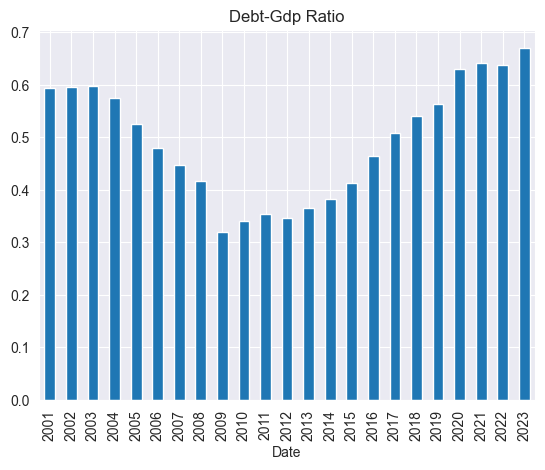

In [28]:
year_avg = df.loc[:, ["Total"]].resample("Y").mean()
year_avg.index = year_avg.index.year
gdp_df_copy = gdp_df.copy()
gdp_df_copy.index = gdp_df_copy.index.year
year_avg = year_avg.join(gdp_df_copy["Nominal_Gdp"], )
year_avg["gdp_debt"] = year_avg["Total"] / year_avg["Nominal_Gdp"]
year_avg["gdp_debt"].plot.bar(title="Debt-Gdp Ratio")

It can be seen prior to 2009 the debt to gdp ratio was on a downward trend, although borrowing at this time was increasing the country's growth was faster than it borrowed. After 2009 the ratio is on an upwrd trend indicating the country is borrowing more than it is making

Next We are gong to look at the data on a month by month lense, since the data is already monthly there is no need of resampling as we did whlile analysing yearly

<Axes: title={'center': '% Changes in Debt per Month 2003 - 2015'}, xlabel='Date'>

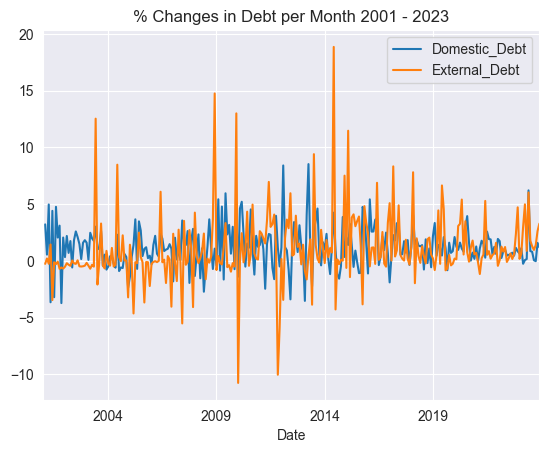

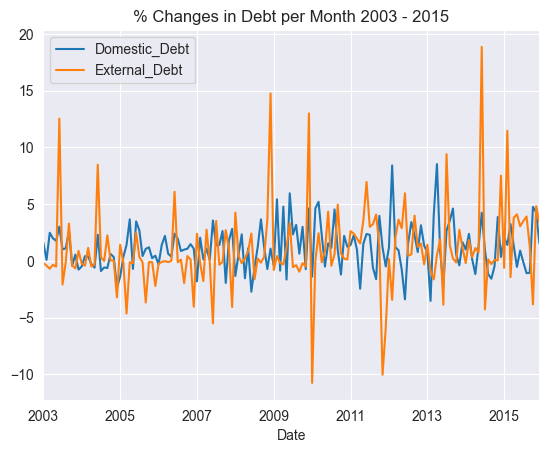

In [29]:
changes_per_month = df.pct_change()*100
changes_per_month.plot(y=["Domestic_Debt", "External_Debt"], title="% Changes in Debt per Month 2001 - 2023")
changes_per_month.loc["2003":"2015"].plot(y=["Domestic_Debt", "External_Debt"], title="% Changes in Debt per Month 2003 - 2015")

For a more granular view, I calculated month-over-month percentage changes.
Monthly debt changes were highly volatile, especially for external debt, which showed more significant spikes.

Zooming into 2003–2015, I observed:

Two major negative spikes around 2010 and late 2011.
Notable domestic debt fluctuations between 2012 and 2014, with two dips and two highs.